# Chapter09 텍스트를 위한 인공 신경망

### 09-1 순차 데이터와 순환 신경망

- 순차 데이터 : 텍스트나 시계열 데이터와 같이 순서에 의미가 있는 데이터

 - 시계열 데이터 : 일정간 시간 간격으로 기록된 데이터

 순서가 중요하므로 '이전에' 입력한 데이터를 기억하는 기능이 필요하다

---

- 피드포워드 신경망 : 입력 데이터의 흐름이 앞으로만 전달되는 신경망

- **순환 신경망** : 이전 데이터가 신경망 층에 순환되는 신경망 (완전 연결 신경망에 순환하는 고리가 추가됨)

 --> '이전 샘플에 대한 기억을 가지고 있다'

### 09-2 순환 신경망으로 IMDB 리뷰 분류하기

IMDB 리뷰 분류 :

댓글을 긍정과 부정으로 분류하는 이진 분류

In [1]:
# IMDB 리뷰 데이터셋 적재

from tensorflow.keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
# num_words: 어휘사전에 저장할 단어의 개수 (500개의 단어만 저장할거다..)
# 어휘사전에 단어가 없으면 2로 표현 (0은 패딩, 1은 문장의 시작을 의미)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [2]:
print(train_input.shape, test_input.shape)

# 텍스트 길이가 제각각이기 때문에 리뷰마다 리스트로 담았다

(25000,) (25000,)


In [3]:
print(len(train_input[0]))   # 218개의 토큰으로 이루어져 있다
print(len(train_input[1]))   # 189개 '' --> 각각 리뷰의 길이가 다름

218
189


In [4]:
print(train_target[:20])   # 타깃값 0(부정), 1(긍정)

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [5]:
# 훈련세트, 검증세트 분리
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [6]:
import numpy as np
lengths = np.array([len(x) for x in train_input])

In [7]:
print(np.mean(lengths), np.median(lengths))   # 리뷰길이의 평균과 중간값

239.00925 178.0


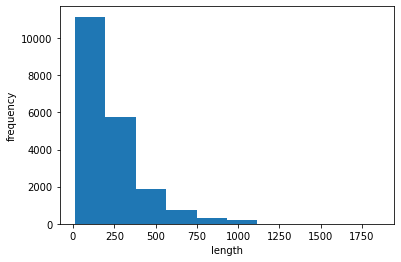

In [8]:
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

이 예제에서는 100개의 단어만 사용할 것이다.

--> 100개보다 작은 리뷰들의 길이를 맞추기 위해 '패딩'이 필요, ( 0으로 )

100개보다 큰 리뷰들을 길이가 100이 되도록 잘라내야함

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences  # 시퀀스 데이터의 길이를 맞춰준다
train_seq = pad_sequences(train_input, maxlen=100)  # 기본적으로 앞부분을 자르거나 추가

In [10]:
print(train_seq.shape)  # 모든 데이터의 리뷰길이가 100이 되었다 --> 2차원 배열이 됨

(20000, 100)


In [11]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [12]:
print(train_input[0][-10:])  # train_input[0]은 앞부분이 잘렸다

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


In [13]:
print(train_seq[5])  # train_seq[5]은 앞부분이 패딩되었다

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [14]:
# 검증세트에도 길이 100으로 맞춰줘야 함
val_seq = pad_sequences(val_input, maxlen=100)

In [15]:
# 순환 신경망 만들기
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))  # 각 리뷰의 길이가 100이고, 500개의 단어만 저장하니까 (100, 500)으로 받음
                                                              # 원-핫 인코딩으로 바꿔 input에 넣어줘야 함
                                                              # -> 단어와 그에 대응하는 정수에는 아무 관련이 없기 때문
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [16]:
train_oh = keras.utils.to_categorical(train_seq)
val_oh = keras.utils.to_categorical(val_seq)

# keras.utils.to_categorical()에 정수형 배열을 입력하면 자동으로 원-핫 인코딩으로 변환해줌

In [17]:
print(train_oh.shape)
print(train_oh[0][0][:12])
print(np.sum(train_oh[0][0]))
# 인코딩 잘됨

(20000, 100, 500)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
1.0


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 8)                 4072      
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 순환신경망 학습하기
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 15s 43ms/step - loss: 0.6984 - accuracy: 0.4963 - val_loss: 0.6950 - val_accuracy: 0.5120
Epoch 2/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6932 - accuracy: 0.5152 - val_loss: 0.6920 - val_accuracy: 0.5196
Epoch 3/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6902 - accuracy: 0.5342 - val_loss: 0.6888 - val_accuracy: 0.5366
Epoch 4/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6867 - accuracy: 0.5513 - val_loss: 0.6849 - val_accuracy: 0.5570
Epoch 5/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6813 - accuracy: 0.5752 - val_loss: 0.6775 - val_accuracy: 0.5900
Epoch 6/100
313/313 [==============================] - 13s 41ms/step - loss: 0.6672 - accuracy: 0.6157 - val_loss: 0.6487 - val_accuracy: 0.6570
Epoch 7/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6268 - accuracy: 0.6771 - val_loss: 0.6182 - val_ac

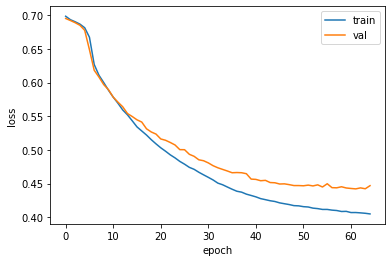

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [21]:
print(train_seq.nbytes, train_oh.nbytes)
print(train_oh.nbytes / train_seq.nbytes) # 원-핫 인코딩으로 변환한 데이터약 500정도 크다 --> 낭비

8000000 4000000000
500.0


단어 임베딩 :

각 단어를 고정된 크기의 실수 벡터로 바꾸어준다.

--> 원-핫 인코딩과는 달리 훨씬 작은 크기로도 단어를 잘 표현할 수 있다.

In [22]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [23]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           8000      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [24]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6973 - accuracy: 0.5042 - val_loss: 0.6952 - val_accuracy: 0.5072
Epoch 2/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6922 - accuracy: 0.5193 - val_loss: 0.6933 - val_accuracy: 0.5126
Epoch 3/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6887 - accuracy: 0.5375 - val_loss: 0.6919 - val_accuracy: 0.5152
Epoch 4/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6855 - accuracy: 0.5530 - val_loss: 0.6910 - val_accuracy: 0.5212
Epoch 5/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6823 - accuracy: 0.5661 - val_loss: 0.6909 - val_accuracy: 0.5230
Epoch 6/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6791 - accuracy: 0.5791 - val_loss: 0.6903 - val_accuracy: 0.5236
Epoch 7/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6758 - accuracy: 0.5875 - val_loss: 0.6903 - val_accuracy:

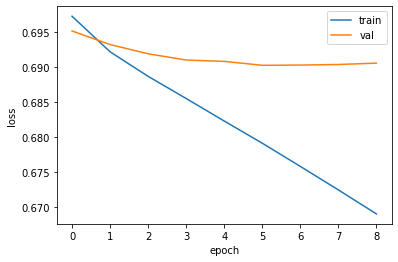

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 09-3 LSTM과 GRU 셀

기본 RNN은 긴 시퀀스를 학습하기 어렵다. --> ( 시퀀스가 갈수록 순환되는 은닉 상태에 담긴 정보가 점차 희석되기 때문 )

- LSTM : 단기 기억을 오래 기억하기 위해 고안되었음

 1. 은닉 상태
 
 2. 셀 상태 : 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 값

In [28]:
# LSTM 신경망 훈련하기
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(
     train_input, train_target, test_size=0.2, random_state=42)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [29]:
# 샘플 길이 100으로 맞추기
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [30]:
# 순환층 생성
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


In [32]:
# 모델 컴파일, 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

# 기본 RNN보다 LSTM이 과대적합을 억제하면서 훈련을 잘 수행한 것으로 보임

Epoch 1/100
313/313 [==============================] - 16s 44ms/step - loss: 0.6926 - accuracy: 0.5258 - val_loss: 0.6919 - val_accuracy: 0.5616
Epoch 2/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6897 - accuracy: 0.6065 - val_loss: 0.6874 - val_accuracy: 0.6304
Epoch 3/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6770 - accuracy: 0.6615 - val_loss: 0.6572 - val_accuracy: 0.6724
Epoch 4/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6229 - accuracy: 0.7186 - val_loss: 0.6085 - val_accuracy: 0.7246
Epoch 5/100
313/313 [==============================] - 13s 42ms/step - loss: 0.5951 - accuracy: 0.7311 - val_loss: 0.5902 - val_accuracy: 0.7320
Epoch 6/100
313/313 [==============================] - 13s 42ms/step - loss: 0.5761 - accuracy: 0.7452 - val_loss: 0.5722 - val_accuracy: 0.7464
Epoch 7/100
313/313 [==============================] - 13s 42ms/step - loss: 0.5580 - accuracy: 0.7552 - val_loss: 0.5554 - val_ac

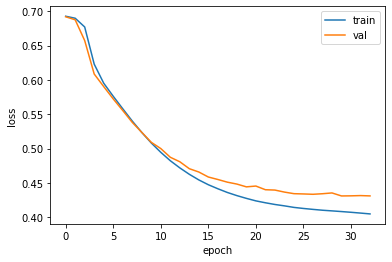

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

순환층에 드롭아웃 적용하기

- dropout : 셀의 입력에 드롭아웃 적용

- recurrent_dropout : 순환되는 은닉상태에 드롭아웃 적용

In [34]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [35]:
# 모델 컴파일, 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

# 드롭아웃이 효과를 잘 발휘해서 과대적합을 억제했다 (검증손실이 조금 향상되었음)

Epoch 1/100
313/313 [==============================] - 16s 46ms/step - loss: 0.6923 - accuracy: 0.5419 - val_loss: 0.6910 - val_accuracy: 0.6168
Epoch 2/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6883 - accuracy: 0.6265 - val_loss: 0.6849 - val_accuracy: 0.6570
Epoch 3/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6774 - accuracy: 0.6687 - val_loss: 0.6668 - val_accuracy: 0.6874
Epoch 4/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6357 - accuracy: 0.7070 - val_loss: 0.5915 - val_accuracy: 0.7344
Epoch 5/100
313/313 [==============================] - 14s 44ms/step - loss: 0.5721 - accuracy: 0.7299 - val_loss: 0.5591 - val_accuracy: 0.7422
Epoch 6/100
313/313 [==============================] - 14s 44ms/step - loss: 0.5447 - accuracy: 0.7467 - val_loss: 0.5321 - val_accuracy: 0.7522
Epoch 7/100
313/313 [==============================] - 14s 44ms/step - loss: 0.5225 - accuracy: 0.7595 - val_loss: 0.5096 - val_ac

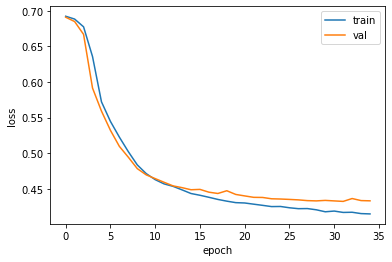

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

2개의 층 연결하기

In [37]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))   # 순환층 2개 연결하기
model3.add(keras.layers.Dense(1, activation='sigmoid'))

In [38]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 8)            800       
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [39]:
# 모델 컴파일, 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 31s 87ms/step - loss: 0.6928 - accuracy: 0.5077 - val_loss: 0.6924 - val_accuracy: 0.5056
Epoch 2/100
313/313 [==============================] - 26s 84ms/step - loss: 0.6898 - accuracy: 0.5796 - val_loss: 0.6864 - val_accuracy: 0.6488
Epoch 3/100
313/313 [==============================] - 26s 84ms/step - loss: 0.6702 - accuracy: 0.6570 - val_loss: 0.6422 - val_accuracy: 0.6742
Epoch 4/100
313/313 [==============================] - 26s 84ms/step - loss: 0.5899 - accuracy: 0.7023 - val_loss: 0.5544 - val_accuracy: 0.7238
Epoch 5/100
313/313 [==============================] - 26s 84ms/step - loss: 0.5392 - accuracy: 0.7349 - val_loss: 0.5175 - val_accuracy: 0.7460
Epoch 6/100
313/313 [==============================] - 26s 84ms/step - loss: 0.5135 - accuracy: 0.7533 - val_loss: 0.4986 - val_accuracy: 0.7632
Epoch 7/100
313/313 [==============================] - 26s 84ms/step - loss: 0.4954 - accuracy: 0.7663 - val_loss: 0.4844 - val_ac

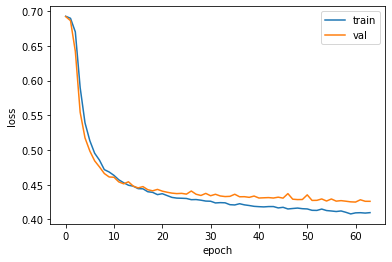

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- **GRU** : LSTM 셀의 간소화된 버전

 LSTM 보다 가중치가 적어 계산량이 적지만 LSTM 못지않은 좋은 성능을 낸다.

In [41]:
# GRU 신경망 훈련하기
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

In [42]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
gru (GRU)                    (None, 8)                 624       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


In [43]:
# 모델 컴파일, 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 17s 47ms/step - loss: 0.6927 - accuracy: 0.5167 - val_loss: 0.6925 - val_accuracy: 0.5292
Epoch 2/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6913 - accuracy: 0.5688 - val_loss: 0.6909 - val_accuracy: 0.5582
Epoch 3/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6890 - accuracy: 0.5929 - val_loss: 0.6880 - val_accuracy: 0.5878
Epoch 4/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6845 - accuracy: 0.6188 - val_loss: 0.6824 - val_accuracy: 0.6136
Epoch 5/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6756 - accuracy: 0.6403 - val_loss: 0.6707 - val_accuracy: 0.6362
Epoch 6/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6569 - accuracy: 0.6655 - val_loss: 0.6442 - val_accuracy: 0.6704
Epoch 7/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6031 - accuracy: 0.7078 - val_loss: 0.5674 - val_ac

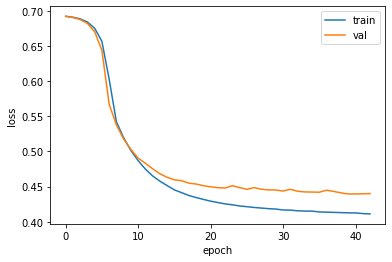

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [45]:
# 가장 좋았던 모델에서 테스트 세트로 평가하기
# 여기서는 2개의 순환층을 쌓은 모델로 적용
test_seq = pad_sequences(test_input, maxlen=100)
rnn_model = keras.models.load_model('best-2rnn-model.h5')
rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 12s 14ms/step - loss: 0.4221 - accuracy: 0.8031


[0.42214256525039673, 0.8031200170516968]